# Convolution


在本文中，我们将使用e3nn实现一个等变卷积。我们将执行这个公式：

$$f_i^{\prime}=\frac{1}{\sqrt{z}} \sum_{j \in \partial(i)} f_j \otimes\left(h\left(\left\|x_{i j}\right\|\right)\right) Y\left(x_{i j} /\left\|x_{i j}\right\|\right)$$

其中：
- $f_j, f_i^{\prime}$节点是输入和输出
- $z$节点的平均度是多少
- $\partial(i)$是节点$i$的邻居集合
- $x_{i j}$是相对向量
- $h$是一个多层感知机
- $Y$是球谐波
- $x \otimes(w) y$是$x$和$y$的张量积$y$被一些权重$w$参数化



## 导入依赖包


In [1]:
import torch
from torch_cluster import radius_graph
from torch_scatter import scatter
from e3nn import o3, nn
from e3nn.math import soft_one_hot_linspace
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'torch_cluster'

让我们首先定义输入和输出特征的不可约表示

In [8]:
irreps_input = o3.Irreps("10x0e + 10x1e")
irreps_output = o3.Irreps("20x0e + 10x1e")
print(irreps_input, irreps_output)

10x0e+10x1e 20x0e+10x1e


In [9]:
irreps_input.dim, irreps_output.dim

(40, 50)

并在相对距离小于$max\_radius$时，使用随机位置和边创建随机图

In [2]:
# create node positions
num_nodes = 100
pos = torch.randn(num_nodes, 3)  # random node positions
print(pos)
# create edges
max_radius = 1.8
edge_src, edge_dst = radius_graph(pos, max_radius, max_num_neighbors=num_nodes - 1)

print(edge_src.shape)

edge_vec = pos[edge_dst] - pos[edge_src]

# compute z
num_neighbors = len(edge_src) / num_nodes
num_neighbors

tensor([[-0.5358,  0.6017, -0.7140],
        [ 0.2415,  0.7564,  0.8313],
        [-0.2683,  1.9618, -0.2649],
        [ 1.4462,  0.8000, -0.3360],
        [ 0.3829,  0.3708,  0.2958],
        [-1.6511, -0.3199,  0.7044],
        [-1.7369,  0.3024,  1.3214],
        [ 1.7310,  0.6407, -0.9080],
        [-2.4387, -0.4614, -2.0060],
        [ 0.5479, -2.2963,  0.6158],
        [ 1.2071, -0.3095,  0.1208],
        [-0.3346, -1.4628,  0.0042],
        [ 0.7984, -0.5852, -0.4228],
        [-0.5329,  0.1377,  0.8437],
        [ 0.1563,  0.8237,  1.5991],
        [-0.0426, -1.5554,  1.1711],
        [ 0.9070, -0.6481,  0.4521],
        [ 0.3006,  0.8725, -0.4966],
        [-0.7882,  0.2184,  0.1806],
        [ 0.2929,  1.5208, -0.3475],
        [ 0.3088, -0.3596,  0.4908],
        [ 0.3916,  1.4814, -1.3773],
        [ 2.4713, -1.4192, -0.9213],
        [ 0.1015,  1.6367, -0.2525],
        [ 0.2854, -2.3640, -0.8459],
        [-1.8756,  1.5843, -1.5428],
        [-0.6508,  0.8970, -0.1198],
 

NameError: name 'radius_graph' is not defined

`edge_src`和`edge_dst`包含每条边的节点索引。我们也可以创建一些随机输入特征。

In [11]:
f_in = irreps_input.randn(num_nodes, -1)
f_in.shape

torch.Size([100, 40])

请注意，我们的数据是以正态分布生成的。我们将按照`component`正则化处理所有数据(参见[正则化](https://docs.e3nn.org/en/latest/guide/normalization.html#norm-guide))。

In [12]:
f_in.pow(2).mean()  # should be close to 1

tensor(0.9857)

让我们从:
$$Y\left(x_{i j} /\left\|x_{i j}\right\|\right)$$



`o3.spherical_harmonics`

$Y^{l+1}_i(x) = \text{cste}(l) \;  C_{ijk} Y^l_j(x) x_k$      
                        
$\partial_k Y^{l+1}_i(x) = \text{cste}(l) \; (l+1)  C_{ijk} Y^l_j(x)$

In [13]:
irreps_sh = o3.Irreps.spherical_harmonics(lmax=2) # 定义输出的维度
print(irreps_sh)
print(irreps_sh.dim)
print(edge_vec.shape)
sh = o3.spherical_harmonics(irreps_sh, edge_vec, normalize=True, normalization='component')
# normalize=True ensure that x is divided by |x| before computing the sh
print(sh.shape)
sh.pow(2).mean()  # should be close to 1

1x0e+1x1o+1x2e
9
torch.Size([3364, 3])
torch.Size([3364, 9])


tensor(1.0000)

现在我们需要计算$\otimes(w)$和$h$, 让我们先创建张量积，它会告诉我们它需要多少权重。

`class FullyConnectedTensorProduct(TensorProduct):`                               
$z_w = \sum_{u,v} w_{uvw} x_u \otimes y_v + \cdots \text{other paths}$

In [14]:
tp = o3.FullyConnectedTensorProduct(irreps_input, 
                                    irreps_sh, 
                                    irreps_output, 
                                    shared_weights=False)

print(f"{tp} needs {tp.weight_numel} weights")

FullyConnectedTensorProduct(10x0e+10x1e x 1x0e+1x1o+1x2e -> 20x0e+10x1e | 400 paths | 400 weights) needs 400 weights


/DYZ/dyz1/anaconda3/envs/gnn/lib/python3.8/site-packages/torch/jit/_check.py:181: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


(<Figure size 432x288 with 1 Axes>, <Axes: >)

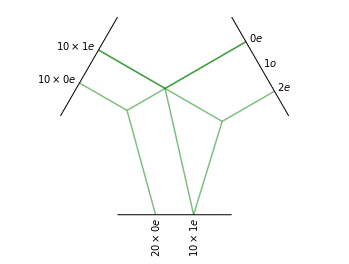

In [16]:
tp.visualize()

在这种特殊的选择中，我们可以看到球面谐波的l=1分量不能用于张量积。在这个例子中，它是反转的等方差，禁止使用l=1。如果我们不想要反转的等方差我们可以声明所有的irreps都是偶数`(irreps_sh = Irreps("0e + 1e + 2e"))`。

为了实现$h$，它必须将相对距离映射到张量积的权重，我们将使用基函数嵌入距离，然后将这个嵌入提供给神经网络。让我们创建嵌入。这是我们将要用到的基本函数



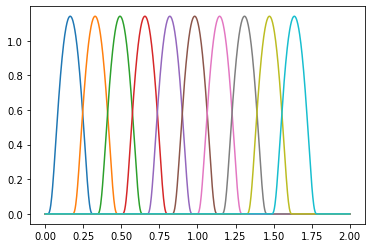

In [17]:
num_basis = 10

x = torch.linspace(0.0, 2.0, 1000)
y = soft_one_hot_linspace(
    x,
    start=0.0,
    end=max_radius,
    number=num_basis,
    basis='smooth_finite',
    cutoff=True,
)

plt.plot(x, y)

注意，这组函数都是光滑的，并且在`max_radius`之外严格为零。这对于得到平滑的卷积很有用，尽管在`max_radius`处有尖锐的截止。

让我们使用这种嵌入的边缘距离，并适当正则化它(`component`，即第二矩接近1)。

`soft_one_hot_linspace`

$y_i(x) = \frac{1}{Z} f_i(x)$

$\langle \sum_{i=1}^N y_i(x)^2 \rangle_x \approx 1$

In [18]:
edge_vec.shape

torch.Size([3364, 3])

In [20]:
print(edge_vec.shape)
edge_length_embedding = soft_one_hot_linspace(
    edge_vec.norm(dim=1),
    start=0.0,
    end=max_radius,
    number=num_basis,
    basis='smooth_finite',
    cutoff=True,
)
edge_length_embedding = edge_length_embedding.mul(num_basis**0.5)

print(edge_length_embedding.shape)
edge_length_embedding.pow(2).mean()  # the second moment

torch.Size([3364, 3])
torch.Size([3364, 10])


tensor(0.9196)

In [21]:
edge_length_embedding.shape

torch.Size([3364, 10])

现在我们可以创建一个MLP并提供给它

In [22]:
tp.weight_numel

400

In [23]:
fc = nn.FullyConnectedNet([num_basis, 16, tp.weight_numel], torch.relu)
print(fc)
weight = fc(edge_length_embedding)

print(weight.shape)
print(len(edge_src), tp.weight_numel)

# For a proper notmalization, the weights also need to be mean 0
print(weight.mean(), weight.std())  # should close to 0 and 1

FullyConnectedNet[10, 16, 400]
torch.Size([3364, 400])
3364 400
tensor(0.0072, grad_fn=<MeanBackward0>) tensor(1.0026, grad_fn=<StdBackward0>)


现在我们可以计算这项了

$$f_j \otimes\left(h\left(\left\|x_{i j}\right\|\right)\right) Y\left(x_{i j} /\left\|x_{i j}\right\|\right)$$

我们的想法是计算每个边的数量，所以我们需要将输入特征提升到边。为此，我们使用`edge_src`，对于每条边，它包含源节点的索引。

In [24]:
f_in

tensor([[ 1.0177, -1.9613,  1.5222,  ...,  1.5351,  0.8969,  0.5273],
        [-0.2905, -1.9319,  0.6774,  ...,  1.2688,  0.2622,  0.0474],
        [-2.1368,  1.2993,  1.0259,  ..., -0.7766, -1.8151, -0.9158],
        ...,
        [ 0.0270, -0.9164,  1.6406,  ..., -1.5145,  0.3836,  0.7888],
        [-1.4170,  0.7813, -0.1696,  ...,  0.5716,  0.4520,  0.1243],
        [-0.3025, -0.8747,  0.9668,  ..., -1.3372, -0.1165,  0.2648]])

In [25]:
f_in[edge_src].shape

torch.Size([3364, 40])

In [28]:
sh.shape

torch.Size([3364, 9])

In [29]:
weight.shape

torch.Size([3364, 400])

In [30]:
summand = tp(f_in[edge_src], sh, weight)

print(summand.shape)
print(summand.pow(2).mean())  # should be close to 1

torch.Size([3364, 50])
tensor(0.9839, grad_fn=<MeanBackward0>)


只剩下相邻项的和

In [33]:
f_out = scatter(summand, edge_dst, dim=0, dim_size=num_nodes)

f_out = f_out.div(num_neighbors**0.5)

f_out.pow(2).mean()  # should be close to 1

tensor(0.8955, grad_fn=<MeanBackward0>)

现在我们可以把所有东西都化成一个函数

In [34]:
def conv(f_in, pos):
    edge_src, edge_dst = radius_graph(pos, max_radius, max_num_neighbors=len(pos) - 1)
    edge_vec = pos[edge_dst] - pos[edge_src]
    sh = o3.spherical_harmonics(irreps_sh, 
                                edge_vec,
                                normalize=True, 
                                normalization='component')
    emb = soft_one_hot_linspace(edge_vec.norm(dim=1), 
                                0.0, 
                                max_radius, 
                                num_basis, 
                                basis='smooth_finite', 
                                cutoff=True).mul(num_basis**0.5)
    return scatter(tp(f_in[edge_src], sh, fc(emb)), edge_dst, dim=0, dim_size=num_nodes).div(num_neighbors**0.5)

现在我们来检查一下等方差

In [36]:
rot = o3.rand_matrix()
D_in = irreps_input.D_from_matrix(rot)
D_out = irreps_output.D_from_matrix(rot)

# rotate before
f_before = conv(f_in @ D_in.T, pos @ rot.T)

# rotate after
f_after = conv(f_in, pos) @ D_out.T

torch.allclose(f_before, f_after, rtol=1e-4, atol=1e-4)

True

张量积支配着执行时间

In [37]:
import time
wall = time.perf_counter()

edge_src, edge_dst = radius_graph(pos, max_radius, max_num_neighbors=len(pos) - 1)
edge_vec = pos[edge_dst] - pos[edge_src]
print(time.perf_counter() - wall); wall = time.perf_counter()

sh = o3.spherical_harmonics(irreps_sh, edge_vec, normalize=True, normalization='component')
print(time.perf_counter() - wall); wall = time.perf_counter()

emb = soft_one_hot_linspace(edge_vec.norm(dim=1), 0.0, max_radius, num_basis, basis='smooth_finite', cutoff=True).mul(num_basis**0.5)
print(time.perf_counter() - wall); wall = time.perf_counter()

weight = fc(emb)
print(time.perf_counter() - wall); wall = time.perf_counter()

summand = tp(f_in[edge_src], sh, weight)
print(time.perf_counter() - wall); wall = time.perf_counter()

scatter(summand, edge_dst, dim=0, dim_size=num_nodes).div(num_neighbors**0.5)
print(time.perf_counter() - wall); wall = time.perf_counter()

0.01329530798830092
0.00214796100044623
0.009131358005106449
0.0012031359947286546
0.005799975013360381
0.0033323090174235404
